In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path, listdir
import sys,os
import sklearn
import pickle
%matplotlib inline
sns.set_style('white')
import hszinc.zincparser

In [2]:
def condition(x):
    if x == "clear":
        return 5
    if x == "partlyCloudy":
        return 4
    if x == "cloudy":
        return 3
    if x == "showers":
        return 2
    if x == "rain":
        return 1
    else: return 0

In [222]:
data = pd.read_csv("..data/power_data.csv")
#data = pd.read_csv("D:/Kodaro/python/forecasting/power_data.csv")
data = data.drop(data.columns[0], axis = 1)
data.columns = ["ts","Power","MallSchOut","Temp","Condition"]
data.head()

,ts,Power,MallSchOut,Temp,Condition
0,2019-05-10 05:00:00-07:00,358.0295829772949 kW,False,72.0 °F,partlyCloudy
1,2019-05-10 06:00:00-07:00,304.00878143310547 kW,False,71.0 °F,partlyCloudy
2,2019-05-10 07:00:00-07:00,537.889518737793 kW,False,72.0 °F,partlyCloudy
3,2019-05-10 08:00:00-07:00,374.89462661743164 kW,False,73.0 °F,partlyCloudy
4,2019-05-10 09:00:00-07:00,1120.6023406982422 kW,False,74.0 °F,partlyCloudy


In [182]:

data["date"] =pd.to_datetime(data['ts'])#.map(lambda x:x.split()[0].replace("T", " ")[:-6]))
data['new_date'] = [d.date() for d in data['date']]
data['new_time'] = [d.time() for d in data['date']]
data["day_week"] = pd.DatetimeIndex(data["date"]).dayofweek
data["day"] = pd.DatetimeIndex(data["new_date"]).day
data["hour"] = pd.DatetimeIndex(data["date"]).hour
#data["min"] = pd.DatetimeIndex(data["date"]).minute
data["Power"] = data["Power"].map(lambda x: float(str(x)[:-2])  )
data["Temp"] = data["Temp"].map(lambda x: float(str(x)[:-2]  )) 
data["BalancePointDiff"] = data["Temp"].apply(lambda x : float(x)-55)
data["Condition"] = data["Condition"].apply(lambda x : condition(x))
data["delta_temp"] = data['Temp'] -data['Temp'].shift(1)
data["MallSchOut"]=data["MallSchOut"].astype(int)
data["Temp"] = data["Temp"].astype(float)
data["week_day"] = (data["day_week"] <5).astype(int)
data.fillna(0,inplace=True)
data = data.drop(["ts", 'date', 'new_date', 'new_time'],axis=1)
#data = data[data["Power"] > 0.0]
data.describe()
data.head()

,Power,MallSchOut,Temp,Condition,day_week,day,hour,BalancePointDiff,delta_temp,week_day
0,358.029583,0,72.0,4,4,10,5,17.0,0.0,1
1,304.008781,0,71.0,4,4,10,6,16.0,-1.0,1
2,537.889519,0,72.0,4,4,10,7,17.0,1.0,1
3,374.894627,0,73.0,4,4,10,8,18.0,1.0,1
4,1120.602341,0,74.0,4,4,10,9,19.0,1.0,1


In [183]:
data.describe()

,Power,MallSchOut,Temp,Condition,day_week,day,hour,BalancePointDiff,delta_temp,week_day
count,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000
mean,1446.941983,0.512797,89.020207,4.092950,3.030085,15.787158,11.521329,34.020207,0.005388,0.709026
std,1002.613399,0.499948,10.480163,0.903661,1.993812,8.834688,6.916513,10.480163,2.080148,0.454314
min,0.000000,0.000000,58.000000,0.000000,0.000000,1.000000,0.000000,3.000000,-5.000000,0.000000
25%,478.476006,0.000000,82.000000,4.000000,1.000000,8.000000,6.000000,27.000000,-2.000000,0.000000
50%,1176.408173,1.000000,91.000000,4.000000,3.000000,16.000000,12.000000,36.000000,-1.000000,1.000000
75%,2406.092316,1.000000,97.000000,5.000000,5.000000,23.000000,18.000000,42.000000,2.000000,1.000000
max,3760.957458,1.000000,111.000000,5.000000,6.000000,31.000000,23.000000,56.000000,7.000000,1.000000


In [189]:
target = data["Power"]
data = data.drop("Power",axis=1)
data.head()

,MallSchOut,Temp,Condition,day_week,day,hour,BalancePointDiff,delta_temp,week_day
0,0,72.0,4,4,10,5,17.0,0.0,1
1,0,71.0,4,4,10,6,16.0,-1.0,1
2,0,72.0,4,4,10,7,17.0,1.0,1
3,0,73.0,4,4,10,8,18.0,1.0,1
4,0,74.0,4,4,10,9,19.0,1.0,1


<BarContainer object of 9 artists>

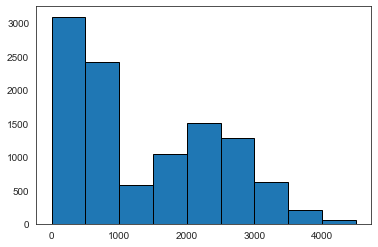

In [45]:

hist, edges = np.histogram(target, bins=np.arange(0,5000,500))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))

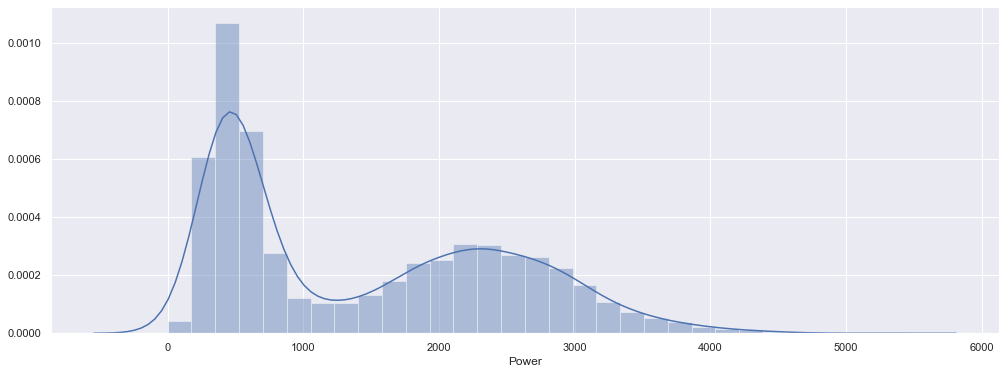

In [61]:
groupbytemp = data.groupby("Power")["hour"].count().reset_index()
groupbytemp.columns = ["Power","freq"]
sns.set(font_scale=1)
plt.figure(figsize=(17, 6))
sns.distplot(data["Power"])

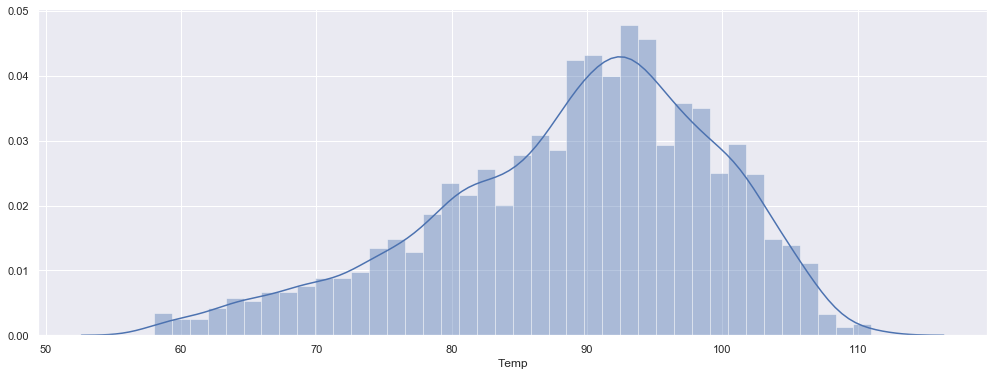

In [52]:
groupbytemp = data.groupby("Temp")["hour"].count().reset_index()
groupbytemp.columns = ["Temp","freq"]
sns.set(font_scale=1)
plt.figure(figsize=(17, 6))
sns.distplot(data["Temp"])

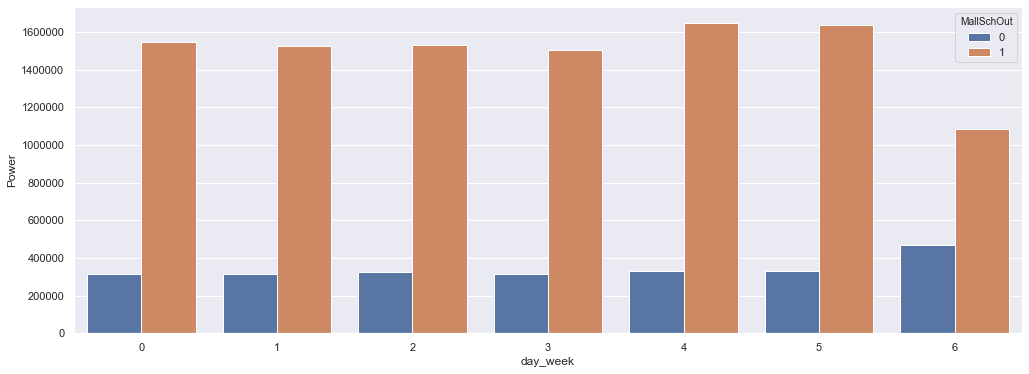

In [66]:
plt.figure(figsize=(17, 6))
metric = data.groupby(["MallSchOut","day_week"])["Power"].sum().reset_index()
sns.barplot(data=metric, x="day_week",y="Power",hue="MallSchOut")

In [190]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    )

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1781 samples.
Testing set has 446 samples.


##### using n_job = -1 uses all the core processor to grid serch the model

In [195]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [196]:
#model.fit(X_train, y_train)
print((rf_random.best_params_))
print(rf_random.score(X_train, y_train))
print(rf_random.score(X_test, y_test))

{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
0.9910625935319949
0.9307397654175915


Feature ranking:
1. feature MallSchOut (0.771092)
2. feature hour (0.105434)
3. feature Temp (0.034463)
4. feature BalancePointDiff (0.032815)
5. feature day (0.022228)
6. feature day_week (0.013692)
7. feature delta_temp (0.009787)
8. feature Condition (0.007557)
9. feature week_day (0.002932)


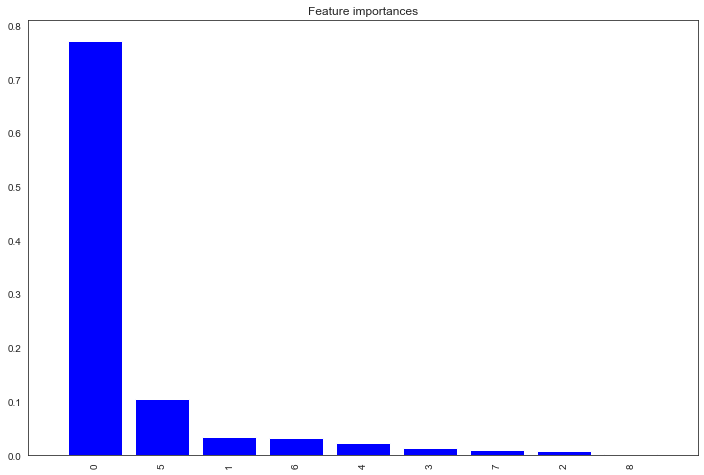

In [192]:
import matplotlib.pyplot as plt
%matplotlib inline
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

#probabilities = reg.predict_proba(X_test)[:, 1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.xticks(rotation='vertical')
plt.show()

#### Feature selection, select feature which contribute to 95% of importance to avoid overfitting

Variable: MallSchOut           Importance: 0.77
Variable: hour                 Importance: 0.11
Variable: Temp                 Importance: 0.03
Variable: BalancePointDiff     Importance: 0.03
Variable: day                  Importance: 0.02
Variable: Condition            Importance: 0.01
Variable: day_week             Importance: 0.01
Variable: delta_temp           Importance: 0.01
Variable: week_day             Importance: 0.0
Number of features for 95% importance: 5


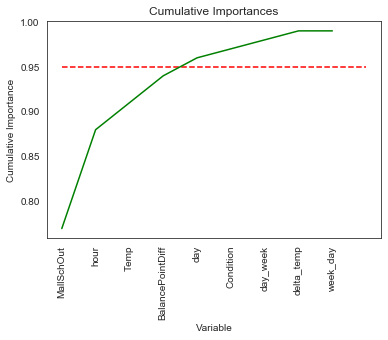

In [193]:
# Get numerical feature importances
importances = list(model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
x_values = list(range(len(importances)))

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

In [10]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection  import GridSearchCV
from sklearn.model_selection  import ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error
def plot_model_test(X, y,X_test,y_test,learner):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], test_size = 0.20, random_state = 0)

    # TODO: Create a decision tree regressor object
    regressor = learner
    reg =  regressor.fit(X,y)
    
    print(learner.__class__.__name__)
    print("r^2 train:",reg.score(X, y))
    print("r^2 test:",reg.score(X_test, y_test))
    y_predict = reg.predict(X_test)
    print("mean Sqr error:",mean_squared_error(y_test,y_predict))
    
    rms =  np.sqrt(((np.array(y_predict) - np.array(y_test)) ** 2).mean())
    print("rmse",rms)#sqrt(mean_squared_error( y_predict,y_test)))
    print("nomalized rmse", (rms/(y_test.mean())*100))
    print()
    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X_test, y_test], axis=1)
    # model values
    model_fitted_y = reg.predict(X_test)


    plot_lm_1, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    p1 = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},ax=axes[0])

    p1.set_title('Residuals vs Fitted')
    p1.set_xlabel('Fitted values')
    p1.set_ylabel('Residuals');
    df_output_compare = pd.DataFrame({'predicted':y_predict, 'actual':y_test})
   
    p2 = sns.regplot(x="actual", y="predicted", data=df_output_compare,ax=axes[1],line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
)

    p2.set_title('Predicted vs Actual')
    p2.set_xlabel('Actual values')
    p2.set_ylabel('Predicted');
    fig, ax = plt.subplots()
    ax = sns.lineplot(ax=ax, x=X_test["hour"], y=y_predict, c="red", label="Predict")
    ax = sns.lineplot(ax=ax,  x=X_test["hour"], y=y_test, c="blue", label="Actual")
    ax.set_title('Hours vs Predicted vs Actual')
    ax.set_xlabel('Hours')
    ax.set_ylabel('Predicted/Actual');
   
    fig.tight_layout()
    #plt.show()
    return reg

In [46]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(np.divide(errors, test_labels, out=np.zeros_like(errors), where=test_labels!=0)  )
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor( random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_train, y_train)

best_random = model
random_accuracy = evaluate(best_random, X_train, y_train)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Performance
Average Error: 70.4233 degrees.
Accuracy = -1220522482050469244585423556001820311552.00%.
Model Performance
Average Error: 63.3661 degrees.
Accuracy = -1091911735973930916419416129829450285056.00%.
Improvement of -10.54%.


RandomForestRegressor
r^2 train: 0.9909395056616279
r^2 test: 0.9260629499779878
mean Sqr error: 69050.22265167533
rmse 262.77409052582664
nomalized rmse 18.704620147958533



C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=270,
                      n_jobs=None, oob_score=False, random_state=40, verbose=0,
                      warm_start=False)

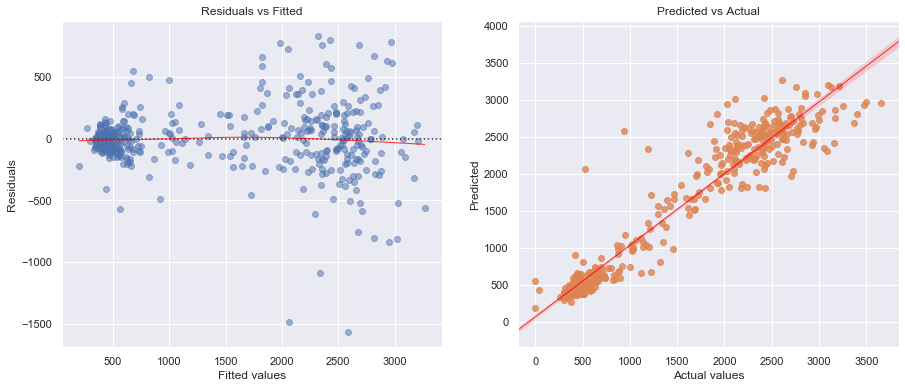

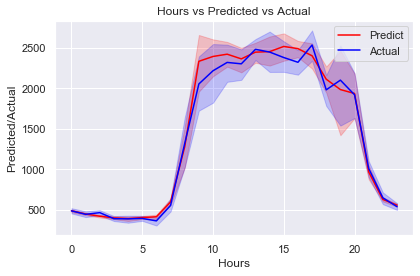

In [77]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
clf = RandomForestRegressor(n_estimators=1400,
 min_samples_split=2,
 min_samples_leaf=1,
 max_features='auto',
 max_depth= 100,
 bootstrap = True)
plot_model_test( X_train, y_train, X_test, y_test, model)

C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor
r^2 train: 0.9879367559850243
r^2 test: 0.9260783868545963
mean Sqr error: 76443.78891344627
rmse 276.4846992393002
nomalized rmse 19.34979962513769



C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


GradientBoostingRegressor
r^2 train: 0.942687261482963
r^2 test: 0.9208802386305905
mean Sqr error: 81819.29586829427
rmse 286.0407241430742
nomalized rmse 20.018578648387773



C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor
r^2 train: 0.9420066046806066
r^2 test: 0.9198526300832467
mean Sqr error: 82881.9660067867
rmse 287.8922819507093
nomalized rmse 20.14816004175482



C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


KNeighborsRegressor
r^2 train: 0.8920797145248202
r^2 test: 0.8544290350548611
mean Sqr error: 150537.78783620606
rmse 387.9919945516996
nomalized rmse 27.153644926423315



C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


LGBMRegressor
r^2 train: 0.942753554940518
r^2 test: 0.9236142529817231
mean Sqr error: 78991.9980449472
rmse 281.05515125139976
nomalized rmse 19.669663005909765



C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\Users\pgujarathi\AppData\Roaming\Python\Python36\site-packages\seaborn\relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


{'RandomForestRegressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=40, verbose=0,
                       warm_start=False),
 'GradientBoostingRegressor': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change

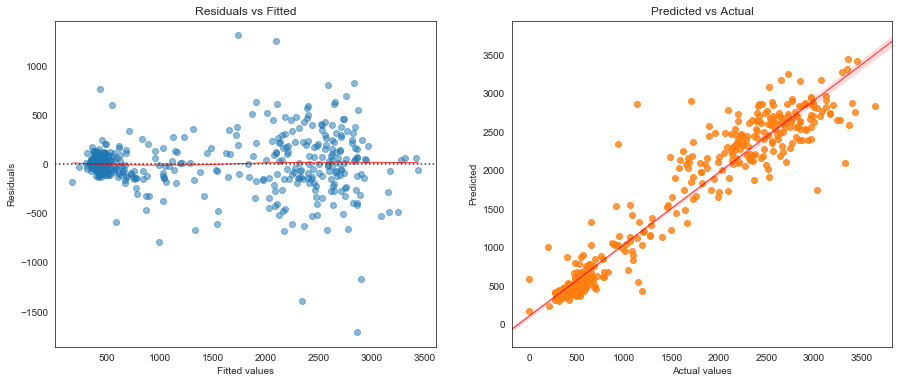

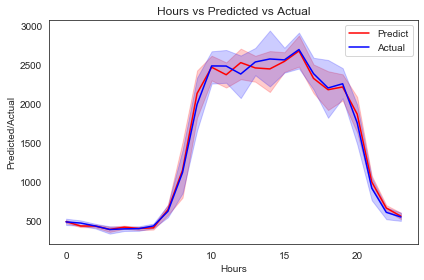

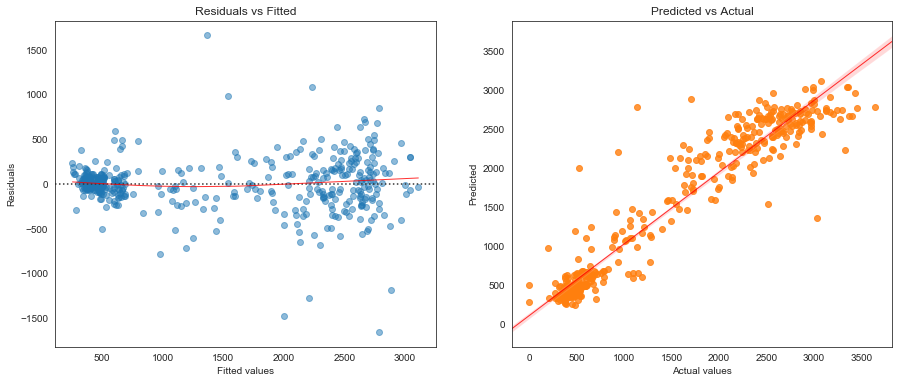

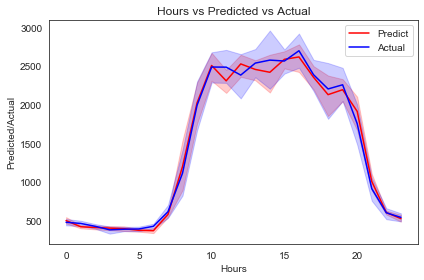

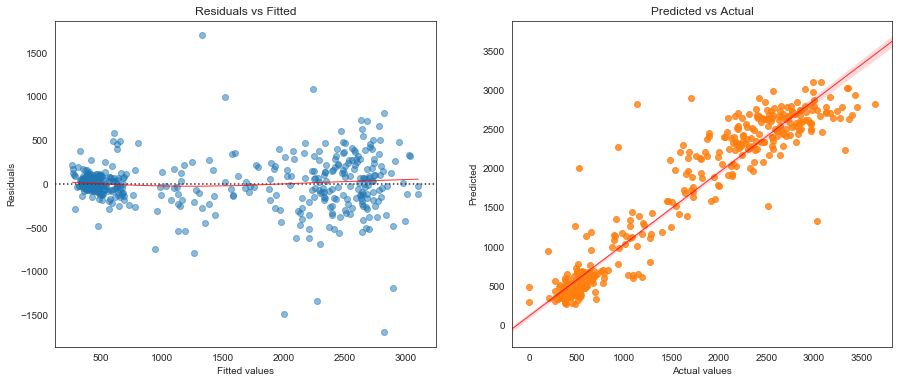

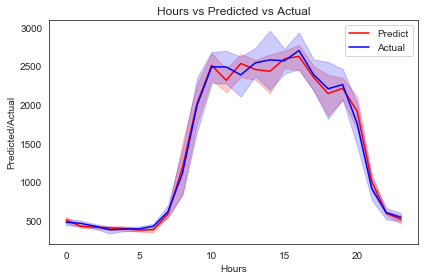

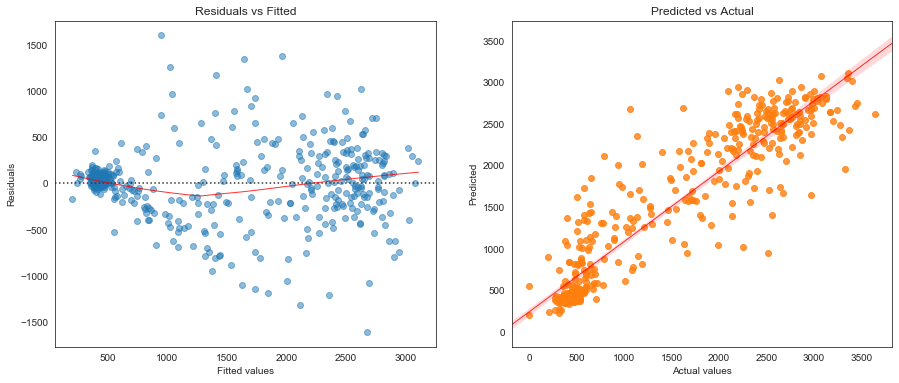

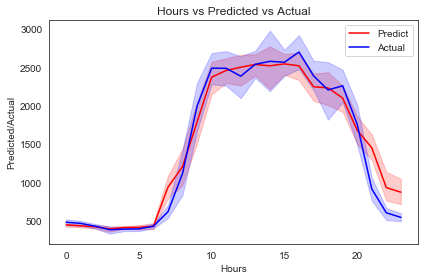

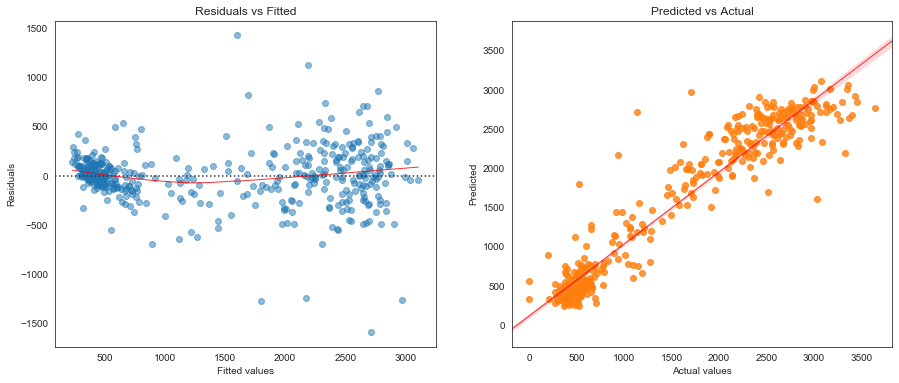

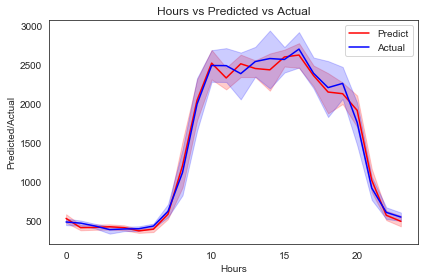

In [194]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
# TODO: Initialize the three models
clf_A =  RandomForestRegressor(random_state=40)
clf_B = GradientBoostingRegressor()
clf_C = XGBRegressor()
clf_D = KNeighborsRegressor()
clf_E = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)



# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C,clf_D,clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    
    results[clf_name]=plot_model_test( X_train, y_train, X_test, y_test, clf)
results